In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
import plotly.offline as po
import plotly.graph_objs as go
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 200)

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
df = pd.read_csv('Terry_Stops.csv')

**Data Cleaning**

In [5]:
df['Precinct'] = df['Precinct'].replace(['SouthWest','-'], ['Southwest','Not Specified']) 
df = df[df.Precinct != 'OOJ']
df = df[df.Precinct != 'FK ERROR']
df = df[df.Precinct != 'Unknown']

df['Officer Race'] = df['Officer Race'].replace('Unknown', 'Not Specified')

df['Subject Perceived Race'] = df['Subject Perceived Race'].replace(['-', 'Unknown'],['Not Specified', 'Not Specified'])
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace('-', 'Unknown')
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace('Unable to Determine', 'Gender Diverse (gender non-conforming and/or transgender)')

df['Call Type'] = df['Call Type'].replace('-','NOT SPECIFIED')

df['Year_of_Report'] = pd.to_datetime(df['Reported Date']).dt.year
df['Year_of_Report'] = df['Year_of_Report'].astype(int)

**First Feature Engineering**

In [6]:
#Creating the feature Arrested
df['Arrested'] = df['Stop Resolution'] == 'Arrest'
df['Arrested'] = df['Arrested'].replace([True, False], [1,0])

#Creating the feature White_Officer
df['White_Officer'] = (df['Officer Race'] == 'White')
df['White_Officer'] = df['White_Officer'].replace([True, False], [1,0])

#Creating the features Subject_POC
df['Subject_POC'] = df['Subject Perceived Race'] != 'White'
df['Subject_POC'] = df['Subject_POC'].replace([True, False], [1,0])

#Creating Hour, Morning, Afternoon, Evening and Night Features
df['Hour'] = pd.to_datetime(df['Reported Time'], format='%H:%M:%S').dt.hour
df['Hour'] = df['Hour'].replace(0,24)
df['Morning'] = (df['Hour'] >= 5) & (df['Hour'] < 12)
df['Morning'] = df['Morning'].replace([True,False], [1,0])
df['Afternoon']= (df['Hour'] >= 12) & (df['Hour'] < 17)
df['Afternoon'] = df['Afternoon'].replace([True,False], [1,0])
df['Evening'] = (df['Hour'] >= 17) & (df['Hour'] < 21)
df['Evening'] = df['Evening'].replace([True,False], [1,0])
df['Night'] = (df['Hour'] >= 21) & (df['Hour'] <= 24)
df['Night'] = df['Night'].replace([True,False], [1,0])

#Creating under_17 feature
df['under_17'] = df['Subject Age Group']=='1 - 17'
df['under_17'] = df['under_17'].replace([True, False], [1,0])


#Creating Officer Age Feature
df['Officer_Age'] = df['Year_of_Report'] - df['Officer YOB']
under_70 = df[df['Officer_Age']<= 70]
df['Officer YOB'] = df['Officer YOB'].astype(int)
mean_age = round(under_70['Officer_Age'].mean(), 0)
df['Officer_Age'] = df['Officer_Age'].replace([120,119,121,118,116,117,115],[mean_age,mean_age,mean_age,mean_age,mean_age,mean_age,mean_age])


**Data Visualizations**

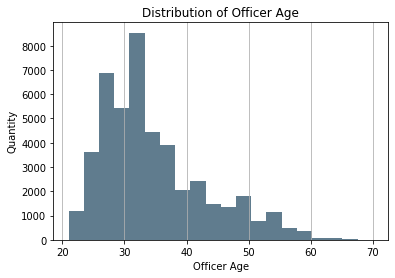

In [7]:
size, scale = 100, 10

df['Officer_Age'].plot.hist(grid=True, bins=20, rwidth=1,
                   color='#607c8e')
plt.title('Distribution of Officer Age')
plt.xlabel('Officer Age')
plt.ylabel('Quantity')
plt.grid(axis='y', alpha=0.75)

Text(0.5, 1.0, 'Stop Resolutions')

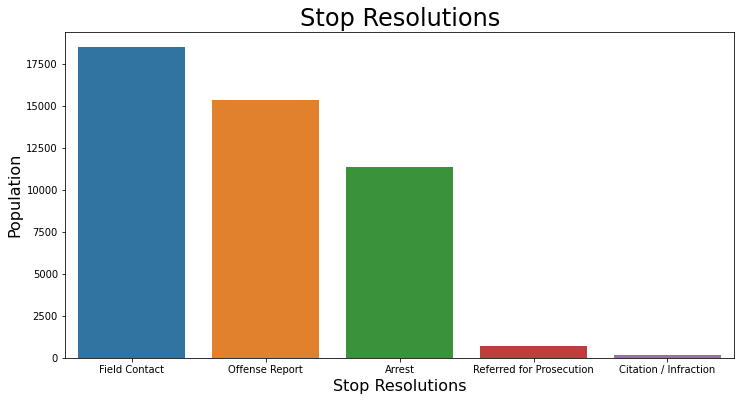

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
x = df['Stop Resolution'].value_counts().index
y = df['Stop Resolution'].value_counts()

sns.barplot(x=x, y=y, ax=ax, data=df)
plt.xlabel("Stop Resolutions", size=16)
plt.ylabel("Population", size=16)
plt.title("Stop Resolutions", size=24)

In [9]:
features = ['Subject Perceived Race','Arrested']
df[features]

,Subject Perceived Race,Arrested
0,White,1
1,Not Specified,0
2,White,0
3,White,0
4,Black or African American,1
...,...,...
46300,Black or African American,0
46301,Black or African American,0
46302,Hispanic,0
46303,Black or African American,0


In [10]:
y = df[features].groupby('Subject Perceived Race').sum()
y

,Arrested
Subject Perceived Race,
American Indian or Alaska Native,387
Asian,419
Black or African American,3809
Hispanic,398
Multi-Racial,162
Native Hawaiian or Other Pacific Islander,14
Not Specified,759
Other,40
White,5354


In [11]:
df['Arrested'].value_counts()

0    34712
1    11342
Name: Arrested, dtype: int64

In [12]:
y.index

Index(['American Indian or Alaska Native', 'Asian',
       'Black or African American', 'Hispanic', 'Multi-Racial',
       'Native Hawaiian or Other Pacific Islander', 'Not Specified', 'Other',
       'White'],
      dtype='object', name='Subject Perceived Race')

## Modeling


### Logistic Regression

In [13]:
features2 = ['White_Officer', 'Subject_POC', 'Officer_Age', 'under_17','Morning', 'Afternoon', 'Evening', 'Night']
y=df['Arrested']
X=df[features2]
df['Arrested'].value_counts()

0    34712
1    11342
Name: Arrested, dtype: int64

In [14]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [15]:
# fitting our data to the logistic regression
logreg = LogisticRegression().fit(X,y)

In [16]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.75


In [17]:
logged_odds = logreg.intercept_
odds = np.exp(logged_odds)
probability = (odds/(1+odds))
print("Null model of probability of being arrested is" + " "+ str(268/(268+500)))
print("The odds of being arrested is" + " " + str(0.34895833/(1-0.34895833)))
print("the logged odds of being arrested is" + " " + str(np.log(odds)))

Null model of probability of being arrested is 0.3489583333333333
The odds of being arrested is 0.53599999213568
the logged odds of being arrested is [-0.53576363]


In [18]:
print(logreg.coef_)
print(logreg.intercept_)

[[ 0.12845906  0.08521887 -0.02238417 -0.17109615  0.11739973  0.02872256
   0.06074673  0.01309005]]
[-0.53576363]


### Decision Tree

In [26]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.30, random_state=0)

In [27]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [34]:
y_pred_dt = classifier.predict(X_test_dt)

**Model Evaluation**

In [29]:
print(confusion_matrix(y_test_dt, y_pred_dt))
print(classification_report(y_test_dt, y_pred_dt))

[[10328    89]
 [ 3359    41]]
              precision    recall  f1-score   support

           0       0.75      0.99      0.86     10417
           1       0.32      0.01      0.02      3400

    accuracy                           0.75     13817
   macro avg       0.53      0.50      0.44     13817
weighted avg       0.65      0.75      0.65     13817



In [30]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10399     0]
 [ 3418     0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     10399
           1       0.00      0.00      0.00      3418

    accuracy                           0.75     13817
   macro avg       0.38      0.50      0.43     13817
weighted avg       0.57      0.75      0.65     13817



/Users/billylopez/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Fixing Class Imbalance Using Oversampling: SMOTE

Fixing Class Imbalance Using Undersampling: Tomek Links